### Install dependencies

In [48]:
# Install required libs
# !python -m pip install --user numpy matplotlib ipython jupyter segmentation-models-pytorch albumentations opencv-python tqdm natsort gdown scikit-image

### Download MHP dataset

In [49]:
# mkdir data/
# Download LV-MHP-v2
# !gdown https://drive.google.com/file/d/1YVBGMru0dlwB8zu1OoErOazZoc8ISSJn/ && unzip data/LV-MHP-v2.zip

### Loading data

In [50]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Helper function to visualize images, masks and predictions

In [52]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### MHP Dataloader

In [53]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from natsort import natsorted
from functools import reduce
from skimage import io

def verify_image(img_file):
    try:
        img = io.imread(img_file)
    except:
        return False
    return True

def get_mask_fp_infos(mask_fp):
    id, num_persons, curr_person = os.path.basename(mask_fp).split(".")[0].split("_")
    return int(id), int(num_persons), int(curr_person)


In [54]:
class Dataset(BaseDataset):
    """MHP v2 Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    CLASS_LABELS = [
        "Background", "Cap/hat","Helmet", "Face", "Hair", "Left-arm", "Right-arm", "Left-hand", "Right-hand", "Protector", 
        "Bikini/bra", "Jacket/windbreaker/hoodie", "Tee-shirt", "Polo-shirt", "Sweater", "Singlet", "Torso-skin", 
        "Pants", "Shorts/swim-shorts", "Skirt", "Stockings", "Socks", "Left-boot", "Right-boot", "Left-shoe",
        "Right-shoe", "Left-highheel", "Right-highheel", "Left-sandal", "Right-sandal", "Left-leg", "Right-leg",
        "Left-foot", "Right-foot", "Coat", "Dress", "Robe", "Jumpsuit" , "Other-full-body-clothes" , "Headwear",
        "Backpack", "Ball", "Bats", "Belt", "Bottle", "Carrybag", "Cases", "Sunglasses", "Eyewear", "Glove",
        "Scarf", "Umbrella"," Wallet/purse", "Watch", "Wristband", "Tie"," Other-accessary", 
        "Other-upper-body-clothes", "Other-lower-body-clothes"
        ]

    def __init__(self, images_dir, masks_dir, size, classes=None, augmentation=None, preprocessing=None):
        self.images_ids = natsorted(os.listdir(images_dir))[0:size]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.images_ids]
        self.masks_ids = natsorted(os.listdir(masks_dir))
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.masks_ids]
    
        # convert str names to class values on masks
        self.class_indices = [self.CLASS_LABELS.index(cls) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        if verify_image(self.images_fps[i]):
            # read image
            image = cv2.imread(self.images_fps[i])
        else:
            image = cv2.imread(self.images_fps[i-1])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # combine mask files
        mask_files_per_image = []
        for el in self.masks_fps:
            mask_id = int(get_mask_fp_infos(el)[0]) 
            img_id = int(self.images_ids[i].split(".")[0])
            if(mask_id == img_id):
                mask_files_per_image.append(el)
        
        mask_files = []
        for file in mask_files_per_image:
            mask_file = cv2.imread(file)
            if mask_file.ndim == 3:
                mask_file = cv2.cvtColor(mask_file, cv2.COLOR_BGR2RGB)
                mask_file = mask_file[:,:,0]
                mask_files.append(mask_file)
        # Create union of all mask files
        combined_file = reduce(lambda array_a, array_b: array_a | array_b, mask_files)

         # extract certain classes from mask (e.g. cars)
        masks = [(combined_file == label_index) for label_index in self.class_indices]
        mask = reduce(lambda array_a, array_b: array_a | array_b, masks)
        if self.class_indices == [0]:
            mask = np.invert(mask)
        mask = mask[:,:, np.newaxis]
        mask = mask.astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask, combined_file=combined_file)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_ids)

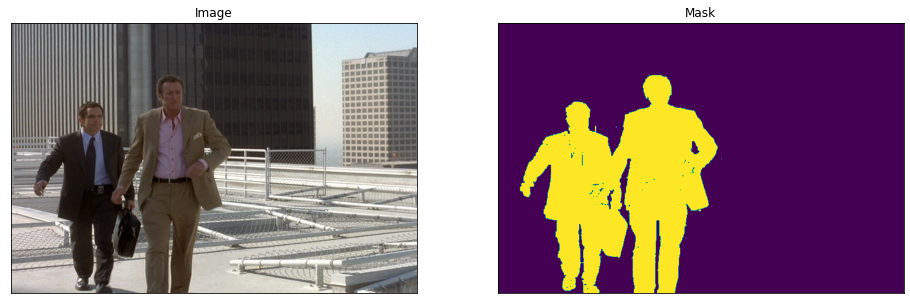

In [55]:
dataset = Dataset("data/LV-MHP-v2/train/images", "data/LV-MHP-v2/train/parsing_annos/", size=2000, classes=['Background'])

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

## VOC Dataloader

In [56]:
from torchvision.datasets import VOCSegmentation
import albumentations as albu


# VOC_CLASSES = [
#     "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", 
#     "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", 
#     "person", "potted plant", "sheep", "sofa", "train", "tv/monitor",
# ]

# VOC_COLORMAP = [
#     [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128], 
#     [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], 
#     [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128],
# ]

class TransformedVOC(VOCSegmentation):
    # def __init__(self, augmentation=None, preprocessing=None, classes=VOC_CLASSES):
    def __init__(self, root, image_set,  augmentation=None, preprocessing=None):
        super(TransformedVOC, self).__init__(root, image_set = image_set)
        # self.classes = classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    # @staticmethod
    # def _convert_to_segmentation_mask(mask, labels):
    #     height, width = mask.shape[:2]
    #     segmentation_mask = np.zeros((height, width, len(labels)), dtype=np.float32)
    #     for idx, label in enumerate(labels):
    #         label_idx = VOC_CLASSES.index(label)
    #         label_color = VOC_COLORMAP[label_idx]
    #         segmentation_mask[:, :, idx] = np.all(mask == label_color, axis=-1).astype(float)
    #     return segmentation_mask

    def __getitem__(self, idx):
        # image = cv2.imread(self.images[idx])
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # mask = cv2.imread(self.masks[idx])
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        # mask = self._convert_to_segmentation_mask(mask, self.classes)

        image, mask = super(TransformedVOC, self).__getitem__(idx)
        image = np.array(image)
        mask = np.array(mask)
        mask = mask.astype('float')
        mask = np.where(mask==15, 1., 0.)
        mask = mask[:,:,np.newaxis]

         # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

### VOC Visualisation

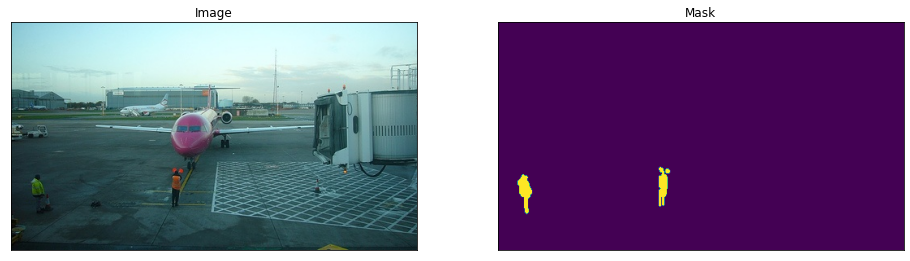

In [57]:
# dataset = TransformedVOC(root="data/", image_set="trainval", classes=["person"])
dataset = TransformedVOC(root="data/", image_set="trainval")

# dataset = VOCSegmentation(root="data/", image_set="trainval")

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

In [58]:
import numbers

IMG_SIZE = 128

#### MHP Augmentations

In [59]:
class HeadCrop(object):
    """Crops the given PIL Image around head region.

    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        offset (int): Offset in y-axis
    """

    def __init__(self, size, offset):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.offset = offset

    def __call__(self, **kwargs):
        image = kwargs.get('image', None)
        mask = kwargs.get('mask', None)
        combined_file = kwargs.get('combined_file', None)
        

        # Extract head region
        head_masks = [(combined_file == label_index) for label_index in [4, 3, 2, 39]]
        head_mask = reduce(lambda array_a, array_b: array_a | array_b, head_masks)
        # Get coordinates of first head pixel
        first_head = np.where(head_mask == True)
        row, col = first_head[0][0], first_head[1][0]
        x_min = max(0, col - self.size[1] // 2)
        y_min = max(0, row + self.offset - self.size[0] // 2)
        x_max = x_min + self.size[1]
        y_max = y_min + self.size[0]
        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]
        return {"image": cropped_image, "mask": cropped_mask}

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [60]:
def get_training_augmentation():
    train_transform = [
        HeadCrop((200, 400), 100),
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        HeadCrop((200, 400), 100),
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')



### VOC Augmentations

In [ ]:
def get_training_augmentation_voc():
    train_transform = [
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation_voc():
    test_transform = [
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(test_transform)

### Preprocessing

In [ ]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Create model

In [61]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [62]:
ENCODER = 'timm-mobilenetv3_small_minimal_100'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['Background']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model1 = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
# create segmentation model with pretrained encoder
model2 = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### Load MHP Dataset

In [63]:
dataset = Dataset(
    "data/LV-MHP-v2/train/images/", 
    "data/LV-MHP-v2/train/parsing_annos", 
    size=1464+1449, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn), 
    classes=CLASSES,
)

dataset_size = len(dataset)
train_size =  int(np.floor(dataset_size*0.5))
valid_size = dataset_size - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)


### Load VOC Dataset

In [64]:
train_dataset_voc = TransformedVOC(
    root="data/", 
    image_set="train", 
    augmentation=get_training_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn)
    )
valid_dataset_voc = TransformedVOC(root="data/", image_set="val", preprocessing=get_preprocessing(preprocessing_fn))


train_loader_voc = DataLoader(train_dataset_voc, batch_size=8, shuffle=True, num_workers=0)
valid_loader_voc = DataLoader(valid_dataset_voc, batch_size=1, shuffle=False, num_workers=0)

## Training

### Defining a loss function

In [65]:
import torch.nn as nn


ALPHA = 0.7
BETA = 0.3
GAMMA = 0.75

class FocalTverskyLoss(nn.Module):
    __name__ = 'focal_tversky_loss'

    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()  
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
        
        return FocalTversky


In [66]:
# loss = smp.utils.losses.DiceLoss()
loss = FocalTverskyLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore()
]

optimizer = torch.optim.Adam([ 
    dict(params=model1.parameters(), lr=0.0001),
])

optimizer2 = torch.optim.Adam([ 
    dict(params=model2.parameters(), lr=0.0001),
])


### Create epoch runners 

In [67]:

# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model1, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model1, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

train_epoch_voc = smp.utils.train.TrainEpoch(
    model2, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer2,
    device=DEVICE,
    verbose=True,
)

valid_epoch_voc = smp.utils.train.ValidEpoch(
    model2, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [68]:
max_score = 0
max_score_voc = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    print("MHP")
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    print("VOC")
    train_logs_voc = train_epoch_voc.run(train_loader_voc)
    valid_logs_voc = valid_epoch_voc.run(valid_loader_voc)
    
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model1, './best_model.pth')
        print('Model saved!')

    # do something (save model, change lr, etc.)
    if max_score_voc < valid_logs_voc['iou_score']:
        max_score_voc = valid_logs_voc['iou_score']
        torch.save(model2, './best_model_voc.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

        


Epoch: 0
MHP
train:   3%|▎         | 5/182 [00:10<06:27,  2.19s/it, focal_tversky_loss - 0.6393, iou_score - 0.2821, fscore - 0.4385]


KeyboardInterrupt: 

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')
best_model_voc = torch.load('./best_model_voc.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    size=1000,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

print("MHP")
logs = test_epoch.run(test_dataloader)

test_epoch_voc = smp.utils.train.ValidEpoch(
    model=best_model_voc,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

print("VOC")
logs_voc = test_epoch_voc.run(test_dataloader)

MHP
valid: 100%|██████████| 1000/1000 [02:01<00:00,  8.24it/s, focal_tversky_loss - 0.1984, iou_score - 0.7843, fscore - 0.8725]
VOC
valid: 100%|██████████| 1000/1000 [02:27<00:00,  6.77it/s, focal_tversky_loss - 0.651, iou_score - 0.2734, fscore - 0.3606]


## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    size=1000,
    classes=CLASSES,
)

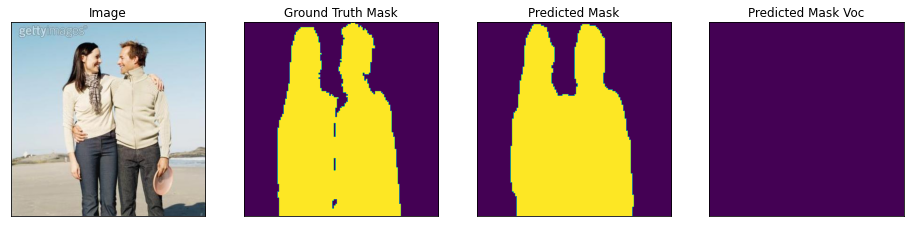

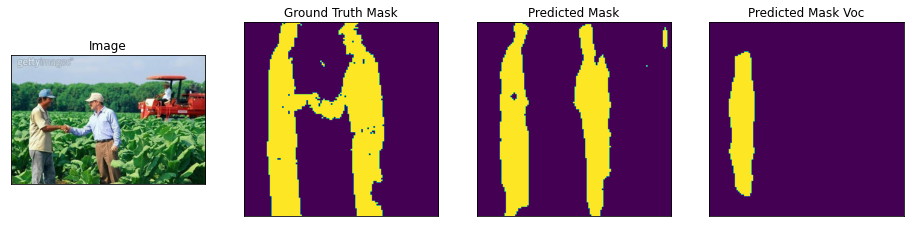

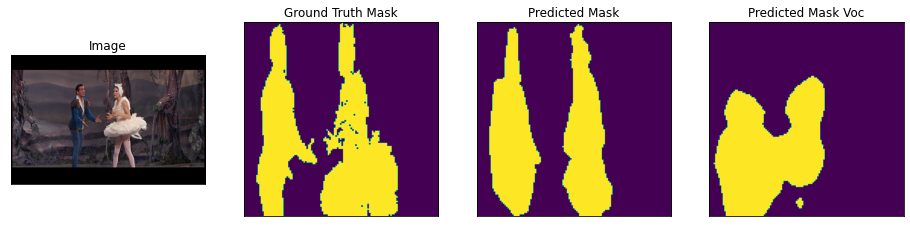

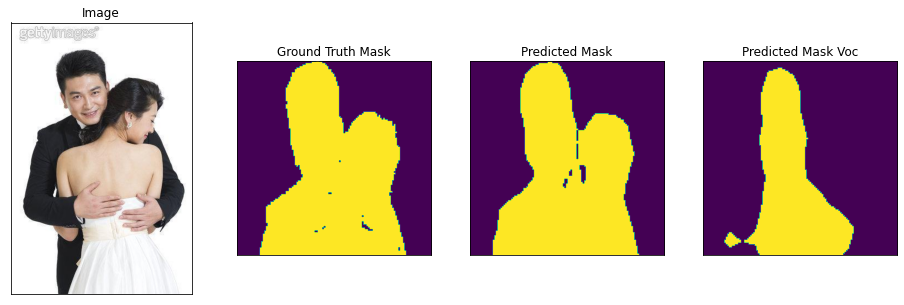

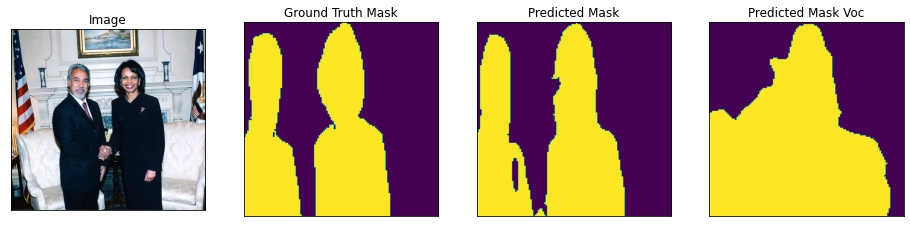

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask_voc = best_model_voc.predict(x_tensor)
    pr_mask_voc = (pr_mask_voc.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask,
        predicted_mask_voc=pr_mask_voc
    )